In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

# Dataset Comparison
This notebook compares both the real and simulated dataset

## Viewing both datasets
We begin with an initial look at both datasets and their fraud-to-non-fraud ratios

In [5]:
# Read and count samples for real kaggle set
kaggle_dataset = pd.read_csv("data/real_data.csv")
# kaggle_dataset = pd.read_csv("../Preparation/data/real_data.csv")
kaggle_non_fraud_counts = kaggle_dataset["Class"].value_counts()[0]
kaggle_fraud_counts = kaggle_dataset["Class"].value_counts()[1]
kaggle_non_fraud_samples = kaggle_dataset.loc[kaggle_dataset["Class"] == 0]
kaggle_fraud_samples = kaggle_dataset.loc[kaggle_dataset["Class"] == 1]

# Read and count samples for simulated set
simulated_test = pd.read_csv("data/synthetic_test.csv")
simulated_train = pd.read_csv("data/synthetic_train.csv")
# simulated_test = pd.read_csv("../Preparation/data/synthetic_test.csv")
# simulated_train = pd.read_csv("../Preparation/data/synthetic_train.csv")
simulated_dataset = pd.concat([simulated_train, simulated_test])
simulated_dataset = simulated_dataset.set_index("Unnamed: 0")

# Rename columns to match real dataset
simulated_dataset = simulated_dataset.rename(columns={"unix_time": "Time", "amt": "Amount", "is_fraud": "Class"})

# $1 inflated to $1.11 from 2013 to 2020, the exchange rate of USD to Euro in 2013 was 0.75
simulated_dataset["Amount"] = simulated_dataset["Amount"].map(lambda x : (x / 1.11) * 0.75)

# Subtract Min UnixTime to start time from first transaction (Like the real dataset)
simulated_dataset["Time"] -= min(simulated_dataset["Time"])

simulated_non_fraud_counts = simulated_dataset["Class"].value_counts()[0]
simulated_fraud_counts = simulated_dataset["Class"].value_counts()[1]

# Check for any null values
print("KAGGLE NULL VALUES:", kaggle_dataset.isnull().values.any())
print("SIMULATED NULL VALUES:", simulated_dataset.isnull().values.any())
print()

# Print number of fraud/non-fraud counts
print("Number of Kaggle samples:")
print(" Non-Fraud:", kaggle_non_fraud_counts)
print("     Fraud:", kaggle_fraud_counts)
print("     Total:", kaggle_non_fraud_counts + kaggle_fraud_counts)
# The classes are heavily skewed we need to solve this issue later.
print("Non-Frauds", round(kaggle_non_fraud_counts/(kaggle_non_fraud_counts + kaggle_fraud_counts) * 100,2), '% of the dataset')
print("Frauds", round(kaggle_fraud_counts/(kaggle_non_fraud_counts + kaggle_fraud_counts) * 100,2), '% of the dataset')
print()
print("Number of Simulated samples:")
print(" Non-Fraud:", simulated_non_fraud_counts)
print("     Fraud:", simulated_fraud_counts)
print("     Total:", simulated_non_fraud_counts + simulated_fraud_counts)
print("Non-Frauds", round(simulated_non_fraud_counts/(simulated_non_fraud_counts + simulated_fraud_counts) * 100,2), '% of the dataset')
print("Frauds", round(simulated_fraud_counts/(simulated_non_fraud_counts + simulated_fraud_counts) * 100,2), '% of the dataset')

KAGGLE NULL VALUES: False
SIMULATED NULL VALUES: False

Number of Kaggle samples:
 Non-Fraud: 284315
     Fraud: 492
     Total: 284807
Non-Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset

Number of Simulated samples:
 Non-Fraud: 1842743
     Fraud: 9651
     Total: 1852394
Non-Frauds 99.48 % of the dataset
Frauds 0.52 % of the dataset


Clearly, both datasets have a significant imbalnce when it comes to fraud samples, but the simulated dataset is ~6x the size of the real one.

## Comparing Time and Amount distributions
In this section, we compare the overall distributions of the only two known shared features in both datasets: time and amount. We begin by extracting the fraudulent and non-fraudulent samples and define some helper functions

In [6]:
# Select same number of samples for simulated set as real kaggle set
simulated_non_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 0]
simulated_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 1]

In [7]:
def print_header(transaction_type):
    if transaction_type.lower() == "fraud":
        # Compare simulated and real amounts for fraud transactions
        print("----------------------------------------------------------------------------")
        print("| FIELDS |   SIMULATED FRAUD  ", "|", "    REAL FRAUD     | DIFFERENCE FROM REAL |")
        print("----------------------------------------------------------------------------")
    else:  
        print("----------------------------------------------------------------------------")
        print("| FIELDS | SIMULATED NON-FRAUD", "|", "  REAL NON-FRAUD   | DIFFERENCE FROM REAL |")
        print("----------------------------------------------------------------------------")

def show_data(simulated, real, transaction_type, field_name):
    print_header(transaction_type)
    fields = ["|  Count", "|   Mean", "|    Std", "|    Min", "|    25%", "|    50%", "|    75%", "|    Max"]
    for i in range(0, 8):
        simulated_string = str(simulated.describe()[i])
        while len(simulated_string) < 20:
            simulated_string = " " + simulated_string
        simulated_string = "|" + simulated_string
        kaggle_string = str(real.describe()[i]) + "|"
        while len(kaggle_string) < 20:
            kaggle_string = " " + kaggle_string
        difference = simulated.describe()[i] - real.describe()[i]
        difference_string = str(difference)
        if difference >= 0:
            difference_string = "+" + difference_string
        while len(difference_string) < 20:
            difference_string = " " + difference_string
        print(fields[i], simulated_string, "|", kaggle_string, difference_string, "|")
    print("----------------------------------------------------------------------------")

    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    sns.distplot(simulated.values, ax=ax[0], color='r')
    ax[0].set_title(f"Synthetic {transaction_type} Transaction {field_name}s", fontsize=14)
    ax[0].set_xlim([min(simulated.values), max(simulated.values)])
    ax[0].set_xlabel(f"{field_name}")

    sns.distplot(real.values, ax=ax[1], color='b')
    ax[1].set_title(f"Real {transaction_type} Transaction {field_name}s", fontsize=14)
    ax[1].set_xlim([min(real.values), max(real.values)])
    ax[1].set_xlabel(f"{field_name}")
    
    if field_name == "Amount" and transaction_type == "Non-Fraud":
        ax[0].set_ylim(0, 0.0025)
        ax[1].set_ylim(0, 0.0025)        
    elif field_name == "Amount" and transaction_type == "Fraud":
        ax[0].set_ylim(0, 0.0040)
        ax[1].set_ylim(0, 0.0040)        
        
    plt.show()

### Comparing Amount

In this section we compare the amounts for fraud and non fraud transactions in the simulated and real datasets

----------------------------------------------------------------------------
| FIELDS | SIMULATED NON-FRAUD |   REAL NON-FRAUD   | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |           1842743.0 |            284315.0|           +1558428.0 |
|   Mean |   45.71032287926938 |   88.29102242231328|    -42.5806995430439 |
|    Std |  103.74872145441397 |  250.10509222589243|  -146.35637077147845 |
|    Min |  0.6756756756756757 |                 0.0|  +0.6756756756756757 |
|    25% |   6.493243243243242 |                5.65|  +0.8432432432432417 |
|    50% |   31.91891891891892 |                22.0|    +9.91891891891892 |
|    75% |  55.783783783783775 |               77.05|  -21.266216216216222 |
|    Max |  19560.067567567567 |            25691.16|   -6131.092432432433 |
----------------------------------------------------------------------------


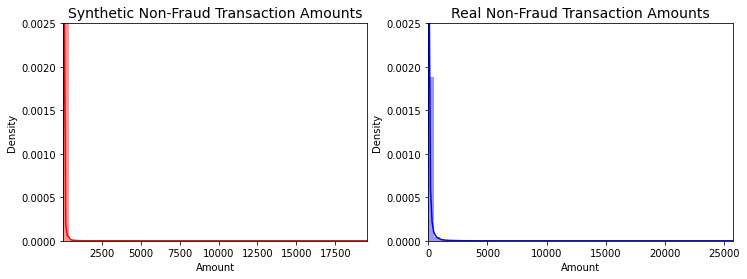

In [8]:
# Compare simulated and real amounts for non-fraud transactions
show_data(simulated_non_fraud_samples["Amount"], kaggle_non_fraud_samples["Amount"], "Non-Fraud", "Amount")

----------------------------------------------------------------------------
| FIELDS |   SIMULATED FRAUD   |     REAL FRAUD     | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |              9651.0 |               492.0|              +9159.0 |
|   Mean |  358.55500830329856 |  122.21132113821139|  +236.34368716508718 |
|    Std |  264.20869778445945 |   256.6832882977121|   +7.525409486747321 |
|    Min |  0.7162162162162162 |                 0.0|  +0.7162162162162162 |
|    25% |   162.2128378378378 |                 1.0|   +161.2128378378378 |
|    50% |   263.5135135135135 |                9.25|   +254.2635135135135 |
|    75% |    609.706081081081 |              105.89|  +503.81608108108105 |
|    Max |   929.7567567567567 |             2125.87|  -1196.1132432432432 |
----------------------------------------------------------------------------


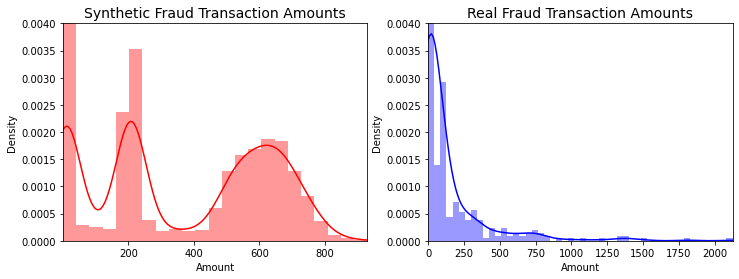

In [9]:
# Compare simulated and real amounts for fraud transactions
show_data(simulated_fraud_samples["Amount"], kaggle_fraud_samples["Amount"], "Fraud", "Amount")

The distribution of the non fraudulent amounts are roughly the same, with the real dataset have a larger standard deviation from the mean compared to the simulated one. However, when it comes to fraudulent transactions, it's clear to see that the simulated dataset "overestimates" the amount spent in a fraudulent transaction in comparison to real data.

#### Comparing similar sample sizes

We now compare similar sample sizes, to try and introduce some stability e.g. make sure that the size of the simulated dataset isn't significantly impacting results

Sampled from Simulated set:
 Non-Fraud: 284315
     Fraud: 492
----------------------------------------------------------------------------
| FIELDS | SIMULATED NON-FRAUD |   REAL NON-FRAUD   | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |            284315.0 |            284315.0|                 +0.0 |
|   Mean |   45.82522718188001 |   88.29102242231328|  -42.465795240433266 |
|    Std |  105.10192789994323 |  250.10509222589243|   -145.0031643259492 |
|    Min |  0.6756756756756757 |                 0.0|  +0.6756756756756757 |
|    25% |   6.486486486486486 |                5.65|  +0.8364864864864856 |
|    50% |  31.979729729729726 |                22.0|   +9.979729729729726 |
|    75% |   55.79054054054053 |               77.05|  -21.259459459459464 |
|    Max |  15383.858108108107 |            25691.16|  -10307.301891891893 |
----------------------------------------------------------------------------


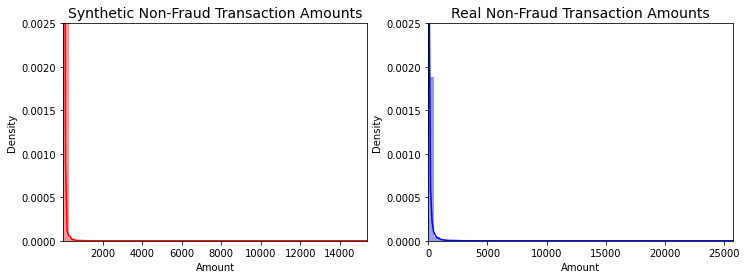

In [10]:
# Select same number of samples for simulated set as real kaggle set
simulated_non_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 0].sample(n=kaggle_non_fraud_counts)
simulated_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 1].sample(n=kaggle_fraud_counts)
print("Sampled from Simulated set:")
print(" Non-Fraud:", simulated_non_fraud_samples.shape[0])
print("     Fraud:", simulated_fraud_samples.shape[0])

# Compare simulated and real amounts for non-fraud transactions
show_data(simulated_non_fraud_samples["Amount"], kaggle_non_fraud_samples["Amount"], "Non-Fraud", "Amount")

----------------------------------------------------------------------------
| FIELDS |   SIMULATED FRAUD   |     REAL FRAUD     | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |               492.0 |               492.0|                 +0.0 |
|   Mean |   353.3752746649087 |  122.21132113821139|  +231.16395352669733 |
|    Std |   255.9156063125394 |   256.6832882977121|  -0.7676819851727146 |
|    Min |  1.7635135135135132 |                 0.0|  +1.7635135135135132 |
|    25% |  167.06587837837836 |                 1.0|  +166.06587837837836 |
|    50% |   275.9662162162162 |                9.25|   +266.7162162162162 |
|    75% |   583.3141891891892 |              105.89|   +477.4241891891892 |
|    Max |   846.2905405405404 |             2125.87|  -1279.5794594594595 |
----------------------------------------------------------------------------


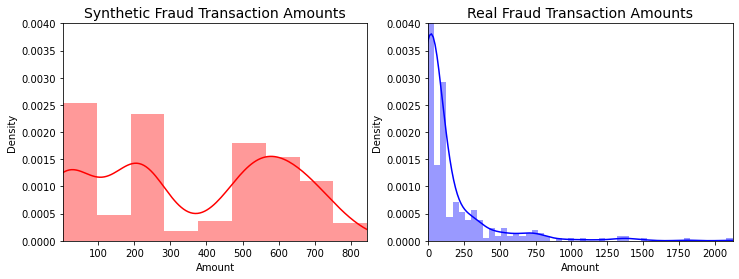

In [11]:
# Compare simulated and real amounts for fraud transactions
show_data(simulated_fraud_samples["Amount"], kaggle_fraud_samples["Amount"], "Fraud", "Amount")

Matching the sample sizes seems to have no effect.

## Comparing Time

Now we compare the times of both datasets

In [12]:
simulated_non_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 0]
simulated_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 1]

----------------------------------------------------------------------------
| FIELDS | SIMULATED NON-FRAUD |   REAL NON-FRAUD   | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |           1842743.0 |            284315.0|           +1558428.0 |
|   Mean |   33315751.69294579 |   94838.20225805884|   +33220913.49068773 |
|    Std |   18194821.00869151 |   47484.01578555077|  +18147336.992905956 |
|    Min |                 0.0 |                 0.0|                 +0.0 |
|    25% |          17669417.5 |             54230.0|          +17615187.5 |
|    50% |          31746876.0 |             84711.0|          +31662165.0 |
|    75% |          49228047.0 |            139333.0|          +49088714.0 |
|    Max |          63158356.0 |            172792.0|          +62985564.0 |
----------------------------------------------------------------------------


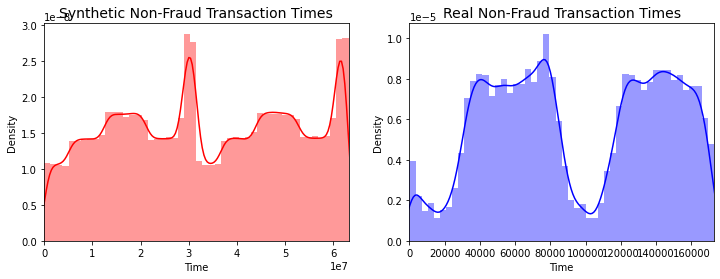

In [13]:
# Compare simulated and real times for fraud transactions
show_data(simulated_non_fraud_samples["Time"], kaggle_non_fraud_samples["Time"], "Non-Fraud", "Time")

----------------------------------------------------------------------------
| FIELDS |   SIMULATED FRAUD   |     REAL FRAUD     | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |              9651.0 |               492.0|              +9159.0 |
|   Mean |  29947074.340172004 |   80746.80691056911|  +29866327.533261433 |
|    Std |  17933616.897800967 |   47835.36513767505|  +17885781.532663293 |
|    Min |             90379.0 |               406.0|             +89973.0 |
|    25% |          14143777.5 |             41241.5|          +14102536.0 |
|    50% |          29899632.0 |             75568.5|          +29824063.5 |
|    75% |          45190695.0 |            128483.0|          +45062212.0 |
|    Max |          62378001.0 |            170348.0|          +62207653.0 |
----------------------------------------------------------------------------


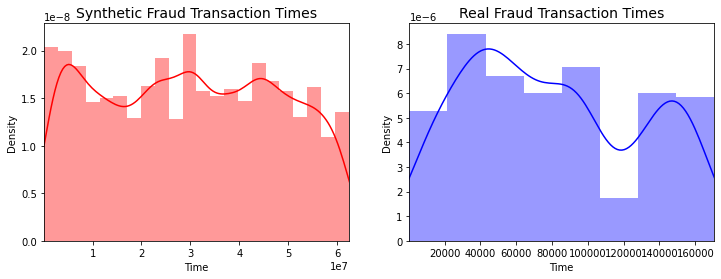

In [14]:
# Compare simulated and real times for fraud transactions
show_data(simulated_fraud_samples["Time"], kaggle_fraud_samples["Time"], "Fraud", "Time")

It is unsurprising in the difference in distributions, considering the significant size differences.

### Comparing Same Range
Now we compare the same "range", by range, we mean that we match the simulated dataset to include all the datapoints within the same time frame as the real one. The real dataset bases time off of seconds since the first transaction, so we do the same for the simulated dataset now.

In [15]:
last_kaggle_time = max(kaggle_non_fraud_samples["Time"])

simulated_non_fraud_times = simulated_non_fraud_samples.loc[simulated_non_fraud_samples["Time"] <= last_kaggle_time]
simulated_fraud_times = simulated_fraud_samples.loc[simulated_fraud_samples["Time"] <= last_kaggle_time]

simulated_non_fraud_times = simulated_non_fraud_times["Time"]
simulated_fraud_times = simulated_fraud_times["Time"]

----------------------------------------------------------------------------
| FIELDS | SIMULATED NON-FRAUD |   REAL NON-FRAUD   | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |              3526.0 |            284315.0|            -280789.0 |
|   Mean |   75418.29211571185 |   94838.20225805884|  -19419.910142346984 |
|    Std |   47183.88788254587 |   47484.01578555077|   -300.1279030049045 |
|    Min |                 0.0 |                 0.0|                 +0.0 |
|    25% |             40106.5 |             54230.0|             -14123.5 |
|    50% |             67018.5 |             84711.0|             -17692.5 |
|    75% |           109719.25 |            139333.0|            -29613.75 |
|    Max |            172786.0 |            172792.0|                 -6.0 |
----------------------------------------------------------------------------


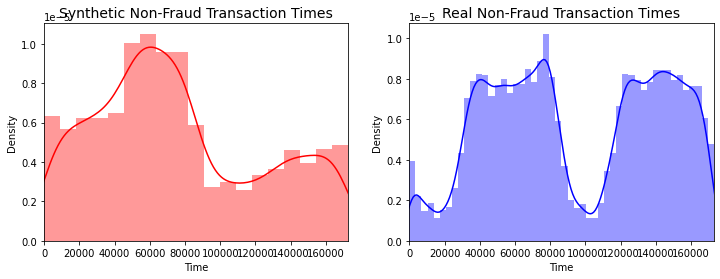

In [16]:
# Compare simulated and real times for fraud transactions
show_data(simulated_non_fraud_times, kaggle_non_fraud_samples["Time"], "Non-Fraud", "Time")

----------------------------------------------------------------------------
| FIELDS |   SIMULATED FRAUD   |     REAL FRAUD     | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |                 7.0 |               492.0|               -485.0 |
|   Mean |  112641.28571428571 |   80746.80691056911|    +31894.4788037166 |
|    Std |  30328.731046727982 |   47835.36513767505|  -17506.634090947067 |
|    Min |             90379.0 |               406.0|             +89973.0 |
|    25% |             95168.0 |             41241.5|             +53926.5 |
|    50% |             99465.0 |             75568.5|             +23896.5 |
|    75% |            117999.5 |            128483.0|             -10483.5 |
|    Max |            172310.0 |            170348.0|              +1962.0 |
----------------------------------------------------------------------------


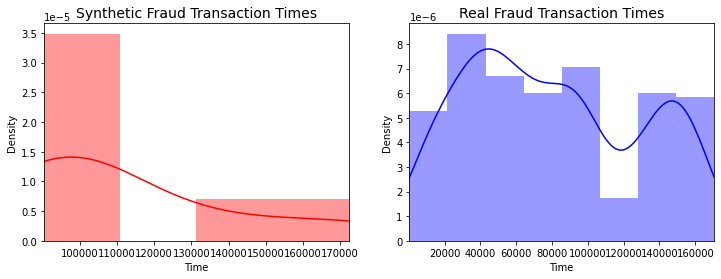

In [17]:
# Compare simulated and real times for fraud transactions
show_data(simulated_fraud_times, kaggle_fraud_samples["Time"], "Fraud", "Time")

Again, the sets seem relatively incomparable

### Comparing Random Sample
Now we select a random sample from the simulated dataset, to match the size of the real one

In [18]:
simulated_non_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 0].sample(n=kaggle_non_fraud_counts)
simulated_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 1].sample(n=kaggle_fraud_counts)

----------------------------------------------------------------------------
| FIELDS | SIMULATED NON-FRAUD |   REAL NON-FRAUD   | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |            284315.0 |            284315.0|                 +0.0 |
|   Mean |   33350058.94713258 |   94838.20225805884|  +33255220.744874522 |
|    Std |  18182315.597301792 |   47484.01578555077|   +18134831.58151624 |
|    Min |               230.0 |                 0.0|               +230.0 |
|    25% |          17711332.0 |             54230.0|          +17657102.0 |
|    50% |          31875444.0 |             84711.0|          +31790733.0 |
|    75% |          49231732.5 |            139333.0|          +49092399.5 |
|    Max |          63158356.0 |            172792.0|          +62985564.0 |
----------------------------------------------------------------------------


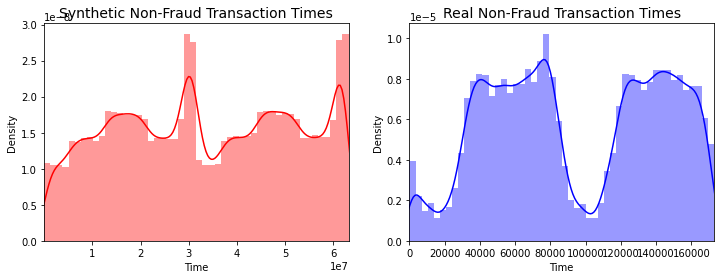

In [19]:
# Compare simulated and real times for fraud transactions
show_data(simulated_non_fraud_samples["Time"], kaggle_non_fraud_samples["Time"], "Non-Fraud", "Time")

----------------------------------------------------------------------------
| FIELDS |   SIMULATED FRAUD   |     REAL FRAUD     | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |               492.0 |               492.0|                 +0.0 |
|   Mean |  31841717.270325202 |   80746.80691056911|   +31760970.46341463 |
|    Std |  18376119.976402916 |   47835.36513767505|  +18328284.611265242 |
|    Min |            100529.0 |               406.0|            +100123.0 |
|    25% |          15633961.0 |             41241.5|          +15592719.5 |
|    50% |          32316644.0 |             75568.5|          +32241075.5 |
|    75% |         46934805.25 |            128483.0|         +46806322.25 |
|    Max |          62377545.0 |            170348.0|          +62207197.0 |
----------------------------------------------------------------------------


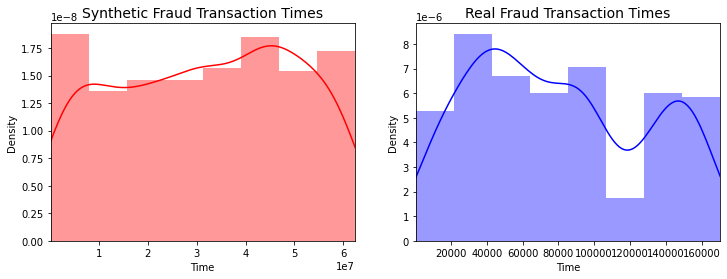

In [20]:
# Compare simulated and real times for fraud transactions
show_data(simulated_fraud_samples["Time"], kaggle_fraud_samples["Time"], "Fraud", "Time")

Time seems to be imcomparable between the two sets. However, both exhibit a "valley" like shape at points, so we look at this now

### Comparing "Similar" Shape

There's a small "valley" type shape in the simualted dataset which is the only thing I can really see that's closest to the real dataset's shape

----------------------------------------------------------------------------
| FIELDS | SIMULATED NON-FRAUD |   REAL NON-FRAUD   | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |           1306129.0 |            284315.0|           +1021814.0 |
|   Mean |  22465631.174907684 |   94838.20225805884|  +22370792.972649626 |
|    Std |  12903426.621561464 |   47484.01578555077|  +12855942.605775913 |
|    Min |                 0.0 |                 0.0|                 +0.0 |
|    25% |          10561148.0 |             54230.0|          +10506918.0 |
|    50% |          23222705.0 |             84711.0|          +23137994.0 |
|    75% |          33492125.0 |            139333.0|          +33352792.0 |
|    Max |          43158309.0 |            172792.0|          +42985517.0 |
----------------------------------------------------------------------------


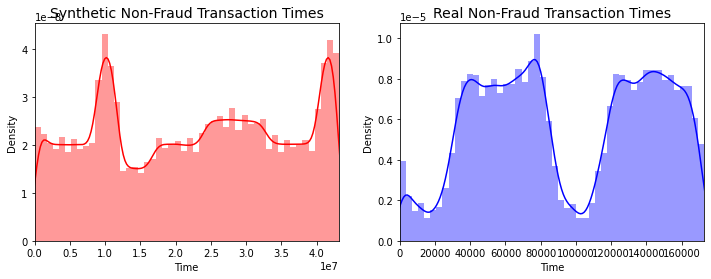

In [21]:
simulated_non_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 0]
simulated_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 1]

lower_range = 20000000

simulated_non_fraud_times = simulated_non_fraud_samples.loc[lower_range <= simulated_non_fraud_samples["Time"]]
simulated_fraud_times = simulated_fraud_samples.loc[lower_range <= simulated_fraud_samples["Time"]]

simulated_non_fraud_times = simulated_non_fraud_times["Time"]
simulated_fraud_times = simulated_fraud_times["Time"]

simulated_non_fraud_times -= min(simulated_non_fraud_times)
simulated_fraud_times -= min(simulated_fraud_times)

# Compare simulated and real times for fraud transactions
show_data(simulated_non_fraud_times, kaggle_non_fraud_samples["Time"], "Non-Fraud", "Time")

----------------------------------------------------------------------------
| FIELDS |   SIMULATED FRAUD   |     REAL FRAUD     | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |              6453.0 |               492.0|              +5961.0 |
|   Mean |  20234634.736711606 |   80746.80691056911|  +20153887.929801036 |
|    Std |  12002944.476298273 |   47835.36513767505|  +11955109.111160597 |
|    Min |                 0.0 |               406.0|               -406.0 |
|    25% |           9870163.0 |             41241.5|           +9828921.5 |
|    50% |          20072964.0 |             75568.5|          +19997395.5 |
|    75% |          30352821.0 |            128483.0|          +30224338.0 |
|    Max |          42358777.0 |            170348.0|          +42188429.0 |
----------------------------------------------------------------------------


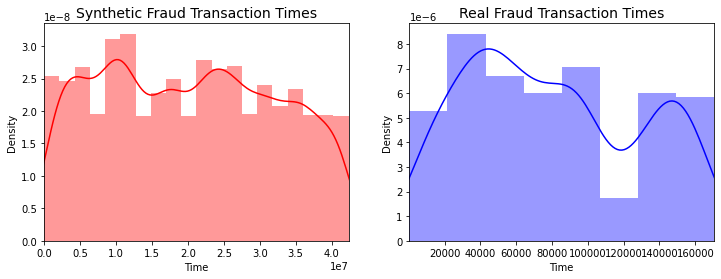

In [22]:
# Compare simulated and real times for fraud transactions
show_data(simulated_fraud_times, kaggle_fraud_samples["Time"], "Fraud", "Time")

### Comparing intervals

Here, we put each time into bins of 24 hours and compare the distribution that way

In [23]:
simulated_non_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 0].sample(n=kaggle_non_fraud_counts)
simulated_fraud_samples = simulated_dataset.loc[simulated_dataset["Class"] == 1].sample(n=kaggle_fraud_counts)

# 86400 seconds in a day
time_hour = lambda x : round((x % 86400) / (86400 / 24)) % 24
time_shift = lambda x : (x - 1) % 24

simulated_non_fraud_times = simulated_non_fraud_samples["Time"].map(time_hour)
simulated_fraud_times = simulated_fraud_samples["Time"].map(time_hour) 

kaggle_non_fraud_times = kaggle_non_fraud_samples["Time"].map(time_hour).map(time_shift)
kaggle_fraud_times = kaggle_fraud_samples["Time"].map(time_hour).map(time_shift)

----------------------------------------------------------------------------
| FIELDS |   SIMULATED FRAUD   |     REAL FRAUD     | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |               492.0 |               492.0|                 +0.0 |
|   Mean |   11.66260162601626 |   11.30691056910569|  +0.3556910569105689 |
|    Std |    9.94588124333663 |   6.748411068029717|   +3.197470175306914 |
|    Min |                 0.0 |                 0.0|                 +0.0 |
|    25% |                 2.0 |                5.75|                -3.75 |
|    50% |                11.0 |                11.0|                 +0.0 |
|    75% |                22.0 |                17.0|                 +5.0 |
|    Max |                23.0 |                23.0|                 +0.0 |
----------------------------------------------------------------------------


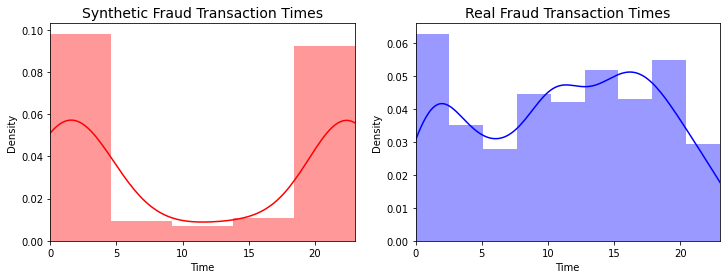

In [24]:
show_data(simulated_fraud_times, kaggle_fraud_times, "Fraud", "Time")

----------------------------------------------------------------------------
| FIELDS | SIMULATED NON-FRAUD |   REAL NON-FRAUD   | DIFFERENCE FROM REAL |
----------------------------------------------------------------------------
|  Count |            284315.0 |            284315.0|                 +0.0 |
|   Mean |  12.694747023547826 |  13.931825615954136|  -1.2370785924063092 |
|    Std |   6.891400898866267 |   5.671455472475301|  +1.2199454263909661 |
|    Min |                 0.0 |                 0.0|                 +0.0 |
|    25% |                 7.0 |                10.0|                 -3.0 |
|    50% |                14.0 |                14.0|                 +0.0 |
|    75% |                19.0 |                19.0|                 +0.0 |
|    Max |                23.0 |                23.0|                 +0.0 |
----------------------------------------------------------------------------


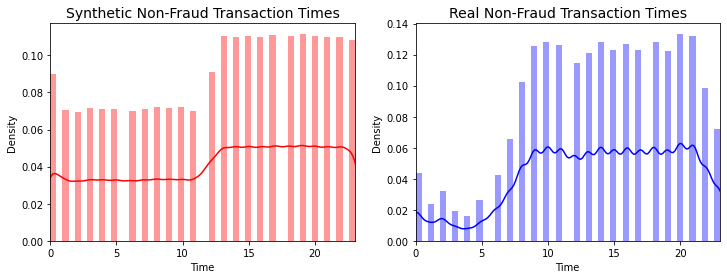

In [25]:
show_data(simulated_non_fraud_times, kaggle_non_fraud_times, "Non-Fraud", "Time")

Again, very different. To summarise, the simulated dataset appears to overestimate the amount spent in a fraudulent transaction, but roughly matches the distribution of the non-fraudulent amounts. Time on the other hand, is very difficult to compare between the two.

# Radar Chart

In [168]:
def prepare_time_data(data,normalise=True) -> list:
    counts=data.value_counts()
    arr=[]
    for i in range(24):
        if i in counts: arr+=[counts[i]]
        else: arr+=[0]
    arr+=[arr[0]]
    
    if normalise:
        max_v=sum(arr[:-1])
        arr=[a/max_v for a in arr]
    
    return arr

In [229]:
def radar_plot(fig:plt.Figure,fraud_data:list,non_fraud_data:list,title=None) -> fig:
    labels=[str(i) for i in range(24)]
    angles=list(np.linspace(0,2*np.pi,24,endpoint=False))
    angles+=[angles[0]]
    
    max_val=max(max(fraud_data),max(non_fraud_data))
    max_val=float(.05*np.ceil(max_val/.05))
    
    # prepare axis
    ax=fig.add_subplot(1,1,1,polar=True)
    ax.set_theta_zero_location("N")
    ax.set_thetagrids([a*180/np.pi for a in angles[:-1]], labels)
    ax.set_rlim(0,max_val)
    r_ticks=list(np.arange(start=0.0,stop=max_val,step=.05))[1:]+[max_val]
    ax.set_rticks(r_ticks)
    ax.margins(0)
    
    if title: ax.set_title(title,fontsize=20)
    
    # plot fraud
    if fraud_data:
        ax.fill(angles,fraud_data,alpha=.2,color="r",label="Fraud")
        ax.plot(angles,fraud_data,color="r")
    
    # plot non-fraud
    if non_fraud_data:
        ax.fill(angles,non_fraud_data,alpha=.2,color="b",label="Non-Fraud")
        ax.plot(angles,non_fraud_data,color="b")
    
    return fig

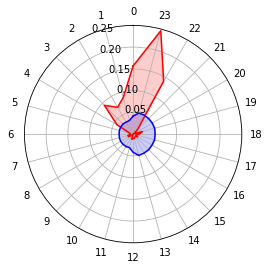

In [233]:
preped_sim_fraud=prepare_time_data(simulated_fraud_times)
preped_sim_non_fraud=prepare_time_data(simulated_non_fraud_times)

fig=plt.figure(figsize=(12,4))

fig=radar_plot(fig,preped_sim_fraud,preped_sim_non_fraud,title=None)

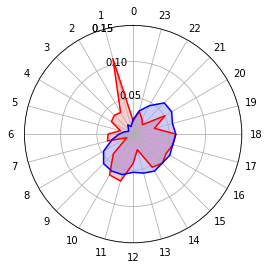

In [232]:
preped_real_fraud=prepare_time_data(kaggle_fraud_times)
preped_real_non_fraud=prepare_time_data(kaggle_non_fraud_times)

fig=plt.figure(figsize=(12,4))

fig=radar_plot(fig,preped_real_fraud,preped_real_non_fraud,title=None)